In [2]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from openomics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap, bar_chart
from moge.network.edge_generator import DataGenerator
from moge.visualization.visualize_embedding import visualize_embedding, plot_bokeh_graph

# from bokeh.io import output_notebook
# output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'openomics'

#  Import network from file

In [2]:
with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
    luad_data = pickle.load(file)

In [3]:
# READ
# with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.train.pickle', 'rb') as file:
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target_cotissexp.train.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.multi_omics_data = luad_data
    network.preprocess_graph()
    network.process_genes_info()

network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if "database" in d and \
                             d["database"]=="NPInter" and u in network.nodes["GE"]])

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 55678
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']


In [4]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target_cotissexp.test.pickle', 'rb') as file:
    network_val = pickle.load(file)
#     network_val.multi_omics_data = luad_data
    network_val.preprocess_graph()
    network_val.process_genes_info()

network_val.G.remove_edges_from([(u,v,d) for u,v,d in network_val.G.edges(data=True) if "database" in d and \
                             d["database"]=="NPInter" and u in network.nodes["GE"]])

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 58986
Genes info columns: ['Disease association', 'locus_type', 'Transcript sequence', 'Chromosome', 'GO Terms', 'Family']


In [5]:
# with open('moge/data/luad_data_shortest.pickle', 'rb') as file:
#     luad_data = pickle.load(file)
#     network.multi_omics_data = luad_data
#     network.process_genes_info()

In [5]:
network.genes_info["Transcript length"] = network.genes_info["Transcript sequence"].apply(lambda x: len(x) if type(x) == str else len(x[np.random.choice(len(x))]) if type(x)==list else None)
network.genes_info["Transcript length"].describe(percentiles=[.50, .75, .85, .90, .95, .99])

count    32741.000000
mean       791.396109
std       1132.424500
min         41.000000
50%        518.000000
75%        726.000000
85%       1112.000000
90%       1697.000000
95%       2553.000000
99%       5047.600000
max      91667.000000
Name: Transcript length, dtype: float64

# Data Visualization

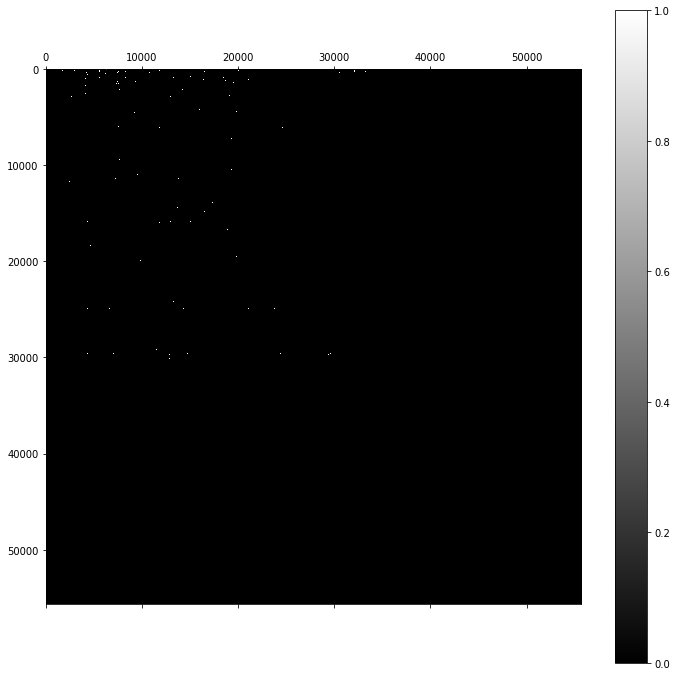

In [5]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

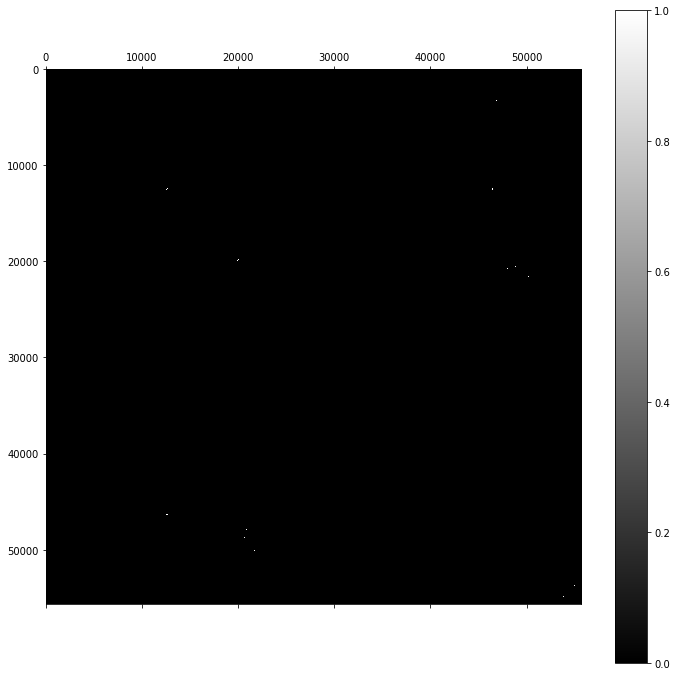

In [6]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

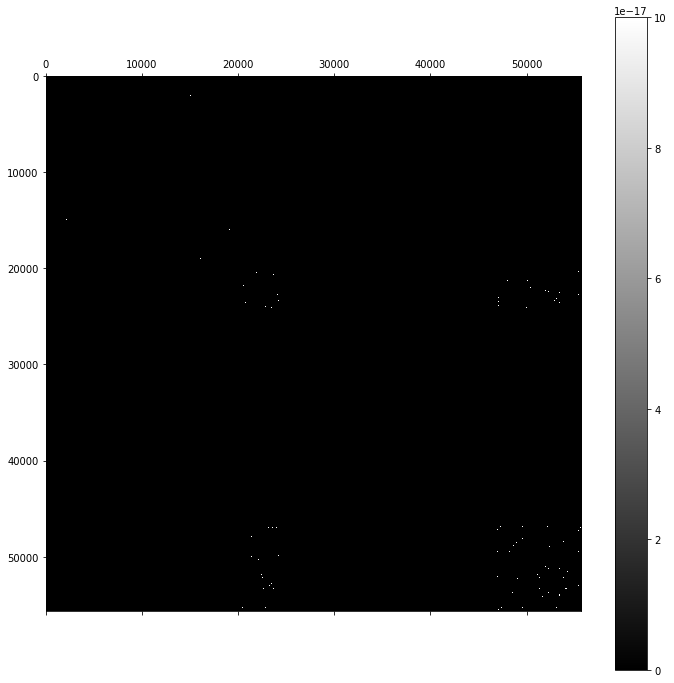

In [7]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list).todense())

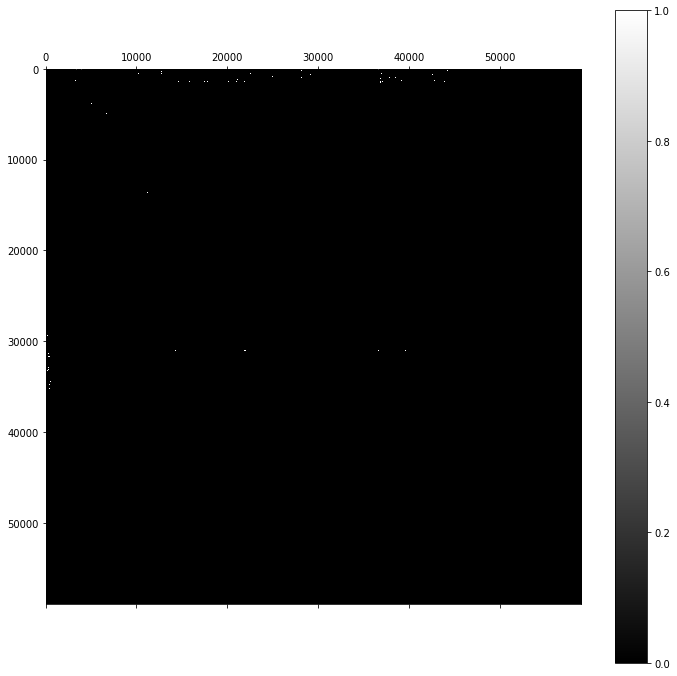

In [8]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [9]:
params = {'weighted': False,
 'undirected_distance': 'euclidean',
 'truncating': 'post',
 'source_target_dense_layers': False,
 'negative_sampling_ratio': 5.0,
 'max_length': 5050,
 'max2_pool_size': 2,
 'max1_pool_size': 9,
 'margin': 1.0,
 'lstm_unit_size': 320,
 'lr': 0.001,
 'embedding_normalization': False,
 'directed_proba': 1.0,
 'directed_distance': 'euclidean',
 'dense2_unit_size': None,
 'dense1_unit_size': 512,
 'd': 128,
 'conv2_kernel_size': 12,
 'conv2_batch_norm': True,
 'conv1_kernel_size': 26,
 'conv1_batch_norm': True,
 'compression_func': 'log'}


In [10]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding
from moge.embedding.siamese_triplet_online_embedding import SiameseOnlineTripletGraphEmbedding

# siamese = SiameseOnlineTripletGraphEmbedding(batch_size=220, margin=params["margin"], epochs=500, verbose=True)
siamese = SiameseGraphEmbedding(batch_size=425, epochs=10, verbose=True)

# siamese = SiameseTripletGraphEmbedding(d=128, batch_size=256, margin=0.2, lr=0.001, epochs=30, 
#     negative_sampling_ratio=2.0, directed_proba=0.8, compression_func="sqrt3",
#     max_length=2000, truncating="post", verbose=True)

siamese.set_params(**params)

SiameseGraphEmbedding(batch_size=425, compression_func='log',
                      conv1_batch_norm=True, conv1_kernel_size=26,
                      conv2_batch_norm=True, conv2_kernel_size=12, d=128,
                      dense1_unit_size=512, dense2_unit_size=None,
                      directed_distance='euclidean', directed_proba=1.0,
                      embedding_normalization=False, epochs=10, lr=0.001,
                      lstm_unit_size=320, margin=1.0, max1_pool_size=9,
                      max2_pool_size=2, max_length=5050,
                      negative_sampling_ratio=5.0, seed=0,
                      source_target_dense_layers=False, subsample=False,
                      truncating='post', undirected_distance='euclidean',
                      verbose=True, weighted=False)

In [7]:
import yaml
with open("logs/SiameseGraphEmbeddin_08-10_01-05AM/params.txt", "r") as file:
    params = yaml.load(str(file.read()))
#     params["subsample"] = False
#     params["batch_size"] = 105
    siamese.set_params(**params)
    file.close()
    
siamese.load_model("logs/SiameseGraphEmbeddin_08-10_01-05AM/lstm_model.h5", network)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


Ed_count: 584633 , Eu_count: 286176 , En_count: 157229
Ens_count: 2923165
word index: {'A': 1, 'G': 2, 'T': 3, 'C': 4}


W0811 13:59:59.256277 140068177884992 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0811 13:59:59.260651 140068177884992 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0811 13:59:59.292886 140068177884992 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0811 13:59:59.294611 140068177884992 deprecation_wrapper.py:119] From /home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/siamese_graph_embedding.py:245: The name tf.Session is deprecated. Please use tf.compat.v

Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 4), dtype=float32, device=/device:GPU:0)
conv2D Tensor("lstm_lambda_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:GPU:0)


W0811 14:00:00.035459 140068177884992 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0811 14:00:00.042229 140068177884992 deprecation.py:506] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


conv1d_2 Tensor("lstm_conv_2/Relu:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:GPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:GPU:0)
embedding Tensor("embedding_output/BiasAdd:0", shape=(?, 128), dtype=float32, device=/device:GPU:0)
Tensor("lstm_network/embedding_output/BiasAdd:0", shape=(425, 128), dtype=float32, device=/device:GPU:0)
Tensor("lstm_network_1/embedding_output/BiasAdd:0", shape=(425, 128), dtype=float32, device=/device:GPU:0)


W0811 14:00:01.705139 140068177884992 deprecation.py:323] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3080: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0811 14:00:01.737246 140068177884992 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Network total weights: 2482836


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_i (InputLayer)        (425, None)          0                                            
__________________________________________________________________________________________________
input_seq_j (InputLayer)        (425, None)          0                                            
__________________________________________________________________________________________________
lstm_network (Model)            multiple             2482836     input_seq_i[0][0]                
                                                                 input_seq_j[0][0]                
__________________________________________________________________________________________________
is_directed (InputLayer)        (425, 1)             0                                            
__________

In [11]:
siamese.learn_embedding(network, network_val=network_val, 
                        multi_gpu=True, rebuild_model=False,
#                         n_steps=2000,
#                         validation_steps=250,
#                         tensorboard=True, embeddings=False, histogram_freq=0,
#                         early_stopping=20,
#                         initial_epoch=0,
                        seed=0),

Ed_count: 584633 , Eu_count: 286176 , En_count: 157229
Ens_count: 2923165
word index: {'A': 1, 'G': 2, 'T': 3, 'C': 4}
Ed_count: 269442 , Eu_count: 524759 , En_count: 347200
Ens_count: 538884


W0816 21:15:43.010128 139989589964608 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0816 21:15:43.012356 139989589964608 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0816 21:15:43.050814 139989589964608 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 21:15:43.052523 139989589964608 deprecation_wrapper.py:119] From /home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/embedding/siamese_graph_embedding.py:245: The name tf.Session is deprecated. Please use tf.compat.v

Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 4), dtype=float32, device=/device:CPU:0)
conv2D Tensor("lstm_lambda_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)


W0816 21:15:43.983142 139989589964608 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0816 21:15:43.988477 139989589964608 deprecation.py:506] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


conv1d_2 Tensor("lstm_conv_2/Relu:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:CPU:0)
embedding Tensor("embedding_output/BiasAdd:0", shape=(?, 128), dtype=float32, device=/device:CPU:0)
Tensor("lstm_network/embedding_output/BiasAdd:0", shape=(425, 128), dtype=float32, device=/device:CPU:0)
Tensor("lstm_network_1/embedding_output/BiasAdd:0", shape=(425, 128), dtype=float32, device=/device:CPU:0)


W0816 21:15:45.263220 139989589964608 deprecation.py:323] From /opt/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3080: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0816 21:15:48.345380 139989589964608 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Network total weights: 2482836
log_dir: logs/SiameseGraphEmbeddin_08-16_21-15PM


W0816 21:15:55.363298 139989589964608 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0816 21:15:55.365259 139989589964608 deprecation_wrapper.py:119] From /opt/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:856: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/10
9296/9296 [==============================] - ETA: 38:25:20 - loss: 3.8241 - precision_d: 0.0000e+00 - recall_d: 0.0000e+ - ETA: 19:54:29 - loss: 3.5612 - precision_d: 0.0000e+00 - recall_d: 0.0000e+ - ETA: 13:42:39 - loss: 2.9926 - precision_d: 0.0000e+00 - recall_d: 0.0000e+ - ETA: 10:34:41 - loss: 2.3522 - precision_d: 0.0000e+00 - recall_d: 0.0000e+ - ETA: 8:57:02 - loss: 1.9307 - precision_d: 0.0240 - recall_d: 0.0061         - ETA: 7:40:24 - loss: 1.6641 - precision_d: 0.0200 - recall_d: 0.005 - ETA: 6:45:05 - loss: 1.4668 - precision_d: 0.0352 - recall_d: 0.026 - ETA: 6:02:50 - loss: 1.3120 - precision_d: 0.0308 - recall_d: 0.023 - ETA: 5:30:21 - loss: 1.2002 - precision_d: 0.0485 - recall_d: 0.045 - ETA: 5:04:14 - loss: 1.1020 - precision_d: 0.0437 - recall_d: 0.041 - ETA: 4:42:52 - loss: 1.0208 - precision_d: 0.0747 - recall_d: 0.042 - ETA: 4:25:06 - loss: 0.9595 - precision_d: 0.0684 - recall_d: 0.039 - ETA: 4:10:11 - loss: 0.9055 - precision_d: 0.0760 - recall_d: 0

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[106,5025,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/RMSprop/gradients/replica_0/model_1/lstm_network_1/conv1_batch_norm/moments/variance_grad/Tile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[training/RMSprop/sub_5/_1809]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[106,5025,320] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training/RMSprop/gradients/replica_0/model_1/lstm_network_1/conv1_batch_norm/moments/variance_grad/Tile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

3 successful operations.
0 derived errors ignored.

# Visualize Embedding

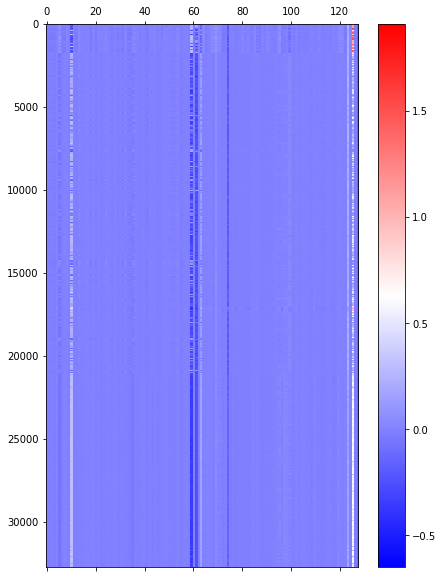

In [12]:
matrix_heatmap(siamese.get_embedding(recompute=True), cmap="bwr", aspect='auto', figsize=(7,10))

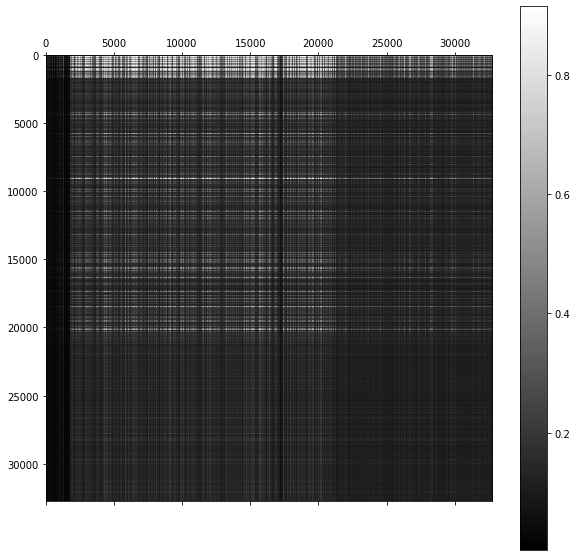

In [13]:
delattr(siamese, "reconstructed_adj") if hasattr(siamese, "reconstructed_adj") else None
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", 
#                                              interpolate=False,
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(),
                                            ), figsize=(10, 10))

beta exp func
mean [[29745.84980151]] median [[237.14101206]] min [[-0.]] max [[3.68413617e+09]]
beta_mean [[237.14101206]]


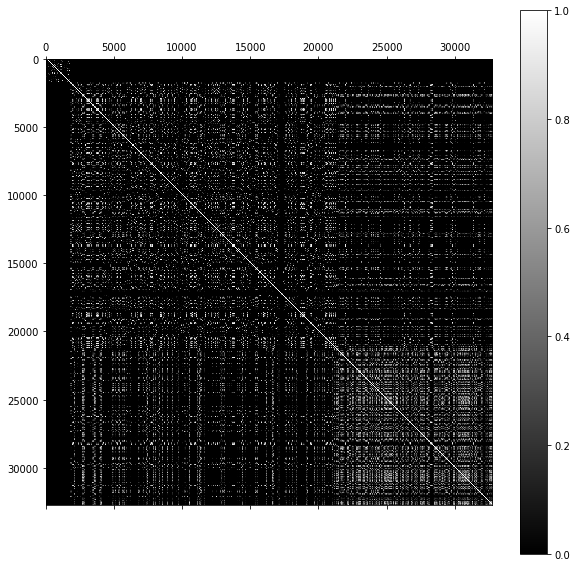

In [14]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", 
#                                              node_l=siamese.generator_train.get_nonzero_nodelist(), 
                                             ), figsize=(10,10))

# Save Model & Embedding

In [ ]:
siamese.save_model("lstm_model.h5", model="lstm", logdir=True)

In [28]:
siamese.truncating = "post"
siamese.save_embeddings("lmn_train.batch_contrastive.euclidean.longest.latest.trunc5050.emb", 
                        variable_length=False, recompute=False, minlen=100)

Saved at logs/SiameseOnlineTriplet_05-29_23-26PM/lmn_train.batch_contrastive.euclidean.longest.latest.trunc5050.emb


In [15]:
siamese.log_dir

'logs/SiameseGraphEmbeddin_08-16_21-15PM'

# Import different models

In [20]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding
from moge.embedding.sequence_based_embedding import iDeepVEmbedding, LncTarInteraction

nodelist = network.genes_info.index.tolist()

# biovec_emb = BioVecEmbedding(network, {"MIR": "moge/data/biovec/miRNA_protvec.model",
#                          "GE": "moge/data/biovec/mRNA_protvec.model",
#                          "LNC": "moge/data/biovec/lncRNA_protvec.model"})

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=nodelist)


biovec_emb = ImportedGraphEmbedding(d=100, method_name="BioVec")
biovec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.biovec.emb", 
                          node_list=nodelist)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=nodelist)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=nodelist)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=nodelist)

rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_train.siamese.multi_seq_UT.biogrid.full.euclidean.trunc.emb", 
                         node_list=network.node_list)
rna2rna_emb.network = network

print()

node2vec imported (21355, 128)
BioVec imported (32707, 100)
LINE imported (21355, 128)
HOPE imported (21355, 128)
SDNE imported (21355, 128)
rna2rna imported (32697, 128)



In [17]:
# rna2rna_graph = nx.from_numpy_matrix(rna2rna_emb.get_reconstructed_adj(), create_using=nx.DiGraph())

In [18]:
# delattr(rna2rna_emb, "reconstructed_adj") if hasattr(rna2rna_emb, "reconstructed_adj") else None
# matrix_heatmap(rna2rna_emb.get_reconstructed_adj())

In [21]:
methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["BioVec"] = biovec_emb
# methods["rna2rna"] = rna2rna_emb
methods["rna2rna"] = siamese

# Prepare Validation Set

In [22]:
generator_val = DataGenerator(network=network_val, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1,
                             training_network=network)
generator_val.on_epoch_end()

Ed_count: 269442 , Eu_count: 524759 , En_count: 347200
Ens_count: 269442
word index: {'A': 1, 'G': 2, 'T': 3, 'C': 4}


lncrna2target
Ed_count: 18013 , Eu_count: 524759 , En_count: 347200 , Ens_count 18013


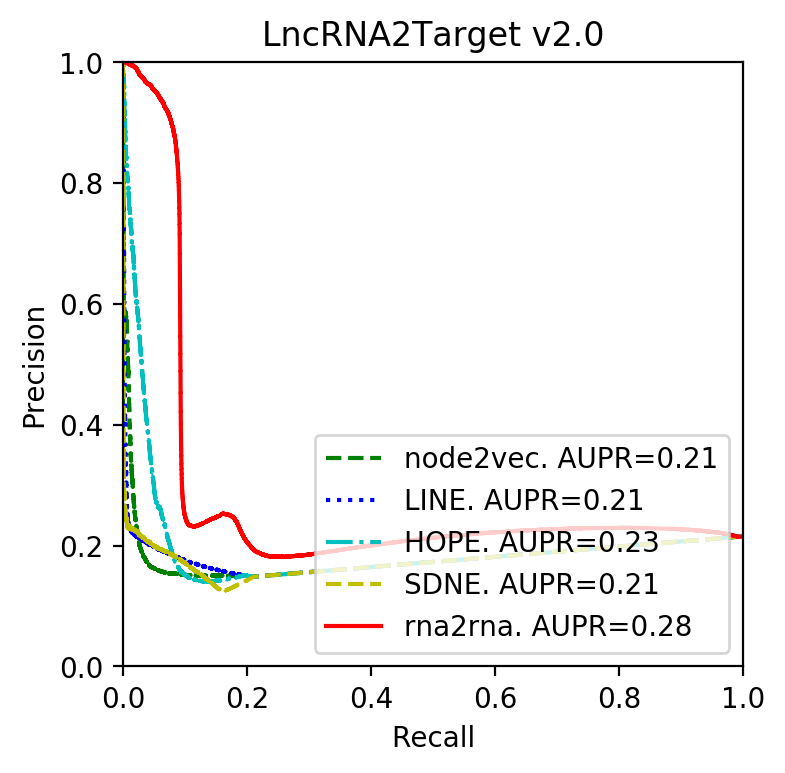

lncBase


In [ ]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_val, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target", "LncRNA2Target v2.0"),
                                            ("MIR", "LNC", "lncBase", "lncBase Predicted"),
                                            ("MIR", "GE", "miRTarBase", "miRTarBase 7.0"), 
                                            ("GE", "GE", "BioGRID", "BioGRID v3.5"), 
                                            (None, None, "NPInter", "NPInter v3.0 "),
#                                             ("LNC", "GE", "lncRInter"),
#                                             ("LNC", "GE", "LncReg"),
                                              ])

In [ ]:
isolates = nx.isolates(network_val.G)
network_val.G.remove_nodes_from(list(isolates))
isolates = nx.isolates(network.G)
network.G.remove_nodes_from(list(isolates))
novel_nodes = list(set(network_val.G.nodes()) - set(network.G.nodes()))
print(len(novel_nodes), {modality:len(set(novel_nodes) & set(network.nodes[modality])) for modality in ["LNC", "MIR", "GE"]})
novel_edges = list(network_val.G.edges(novel_nodes, data=True))
print(len(novel_edges))
network_val.G.clear()
network_val.G.add_edges_from(novel_edges)

generator_val_novel = DataGenerator(network=network_val, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1,
                             training_network=network)
generator_val_novel.on_epoch_end()

In [ ]:
evaluate_pr_curve_link_pred_by_database(methods, generator_val_novel, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target", "LncRNA2Target v1.0"),
                                            ("MIR", "LNC", "lncBase", "lncBase v2"),
                                            ("MIR", "GE", "miRTarBase", "miRTarBase 6.0"), 
                                            ("GE", "GE", "BioGRID", "BioGRID v3.4"), 
                                            (None, None, "NPInter", "NPInter v2.0 "),
#                                             ("LNC", "GE", "lncRInter"),
#                                             ("LNC", "GE", "LncReg"),
                                              ])
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_lncbase_mirtarbase_biogrid_npinter_lncrna2target.test.pickle', 'rb') as file:
    network_val = pickle.load(file)

# Prepare Training set (for graph reconstruction)

In [ ]:
from moge.network.edge_generator import DataGenerator

generator_train = DataGenerator(network=network, 
                             negative_sampling_ratio=1.0,
                             batch_size=1,
#                              maxlen=siamese.max_length,
                             truncating="post",
                             shuffle=True, seed=1)
generator_train.Eu_count = 0
# generator_train.Ed_count = 1000
# generator_train.Eu_count = 1000
generator_train.En_count = 0
generator_train.on_epoch_end()

In [ ]:
from moge.evaluation.link_prediction import evaluate_pr_curve_link_pred, evaluate_pr_curve_link_pred_by_database
# evaluate_pr_curve_link_pred(methods, X, y_true)
evaluate_pr_curve_link_pred_by_database(methods, generator_train, 
                                        tests=[
                                            ("LNC", "GE", "lncrna2target", "LncRNA2Target v1.0"),
                                            ("MIR", "LNC", "lncBase", "lncBase v2"),
                                            ("MIR", "GE", "miRTarBase", "miRTarBase 6.0"), 
                                            ("GE", "GE", "BioGRID", "BioGRID v3.4"), 
                                            (None, None, "NPInter", "NPInter v2.0 "),
                                              ])

# Experimental Results

In [ ]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

database_tests = [
    ("LNC", "GE", "lncrna2target"),
    ("MIR", "LNC", "lncBase"),
    ("MIR", "GE", "miRTarBase"), 
    ("GE", "GE", "BioGRID"), 
    ("LNC", "MIR", "NPInter"),
#     ("LNC", "MIR", "lncRInter"),
    # ("LNC", "GE", "LncReg"),
]
top_k = 5000

for source, target, database in database_tests:
    print(database)
    results = {}
    for method in methods.keys():
        results[method] = \
              evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                                       node_list=set(network.nodes[source])|set(network_val.nodes[source]), 
                                       node_list_B=set(network.nodes[target])|set(network_val.nodes[target]), 
                                       edge_type="d", databases=[database], top_k=top_k)
        
    bar_chart(results, measures=['precision', 'recall'], 
              title="Top-k (k={}) Predictions on {}".format(top_k, database))

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="locus_type", 
                                          max_clusters=500, n_clusters=None)
print(results)
bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'],
         title="Clustering Evaluation to {}".format("RNA Type"))

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

results = {}
for method in methods.keys():
    results[method] = evaluate_clustering(methods[method], network=network, node_label="Family", 
                                          max_clusters=1000, n_clusters=None)
print(results)
bar_chart(results, measures=['homogeneity', 'completeness', 'nmi'], 
          title="Clustering Evaluation to {}".format("RNA Family"))

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Family", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.node_classification import evaluate_classification

results = {}
for method in methods.keys():
    result = {k: np.average(v) for k,v in evaluate_classification(methods[method], network, cv=10,
                                  node_label="Disease association", multilabel=True,
                                  scoring=['precision_macro', 'recall_macro', "f1_macro"],
                                                                verbose=True).items()}
    results[method] = result
    
bar_chart(results, measures=['test_precision_macro', 'test_recall_macro', 'test_f1_macro'])

In [ ]:
from moge.evaluation.utils import get_scalefree_fit_score

results = {}
modalities = [("MIR", "LNC"), ("LNC", "MIR"), ("LNC", "GE"), ("MIR", "GE"), ("GE", "GE")]
labels = ["miRNA-lncRNA", "lncRNA-miRNA", "lncRNA-mRNA", "miRNA-mRNA", "mRNA-mRNA"]
databases = ["lncBase", "NPInter", "lncrna2target", "miRTarBase", "BioGRID"]

for method in ["Databases"]+list(methods.keys()):
    if method == "BioVec":
        continue
    elif method == "Databases":
        sub_result = {}
        for (A, B), label, database in zip(modalities, labels, databases):
            adj = network.get_adjacency_matrix(edge_types=["d"], 
                                               node_list=network.node_list,
                                               databases=[database,])
            network_degrees = np.sum(adj, axis=1)
            sub_result[label] = get_scalefree_fit_score(network_degrees, plot=False)
        results[method] = sub_result
    else:
        sub_result = {}
        for (A, B), label in zip(modalities, labels):
           sub_result[label] = methods[method].get_scalefree_fit_score(network.nodes[A], network.nodes[B])
        results[method] = sub_result
    
bar_chart(results, measures=labels, title="Scale-free fit scores", loc="lower right")

# Visualize lncRNA Subgraphs

In [ ]:
modalities = [("MIR", "LNC", "lncBase"), 
              ("LNC", "MIR", "NPInter"), 
              ("LNC", "GE", "lncrna2target"), 
              ("MIR", "GE", "miRTarBase"), 
              ("GE", "GE", "BioGRID")
             ]

nodes_inters_dict = {}
for A, B, database in modalities:
    edge_list = [(u,v,d) for u,v,d in network.G.edges(data=True) if "database" in d and d["database"]==database and\
                u in network.nodes[A] and v in network.nodes[B]]
    nodes_inters_dict[(A, B)] = {}
    nodes_inters_dict[(A, B)][A] = {u for u,v,d in edge_list}
    nodes_inters_dict[(A, B)][B] = {v for u,v,d in edge_list}

In [33]:
nodes_inters_dict_2 = dict.fromkeys(siamese.node_list, 0)

for A, B, database in modalities:
    if database == "BioGRID": continue
    for node in nodes_inters_dict[(A, B)][A]:
        if node in nodes_inters_dict_2:
            nodes_inters_dict_2[node] = nodes_inters_dict_2[node] + 1
    for node in nodes_inters_dict[(A, B)][B]:
        if node in nodes_inters_dict_2:
            nodes_inters_dict_2[node] = nodes_inters_dict_2[node] + 1
        
trimodule_nodes = [k for k,v in nodes_inters_dict_2.items() if (k in network.nodes["LNC"] and v >= 2) or \
                   (k in network.nodes["MIR"] and v >= 2) or \
                  (k in network.nodes["GE"] and v >= 2)]
[(m, len(set(trimodule_nodes) & set(network.nodes[m]))) for m in ["LNC", "MIR", "GE"]]

[('LNC', 248), ('MIR', 909), ('GE', 8837)]

In [ ]:
g = network.G.subgraph(trimodule_nodes).to_undirected()
center_node = "HOTAIR"
nodelist = list(g.neighbors(center_node))+[center_node]
len(nodelist)

In [ ]:
predicted_edges = siamese.get_top_k_predicted_edges(edge_type="d", top_k=50, 
                                  node_list=[center_node],
                                  node_list_B=siamese.node_list,
                                  training_network=network,)
predicted_edges[:20]

In [ ]:
n_pred_edges = 10
predicted_edges_filter = [(u,v) for u,v,d in predicted_edges[:n_pred_edges] if u in siamese.node_list and v in siamese.node_list]
nodelist = list(set(nodelist) | {node for pair in predicted_edges_filter for node in pair})
true_edges = network.get_edgelist(node_list=nodelist, inclusive=True)
edgelist = true_edges + predicted_edges_filter
edge_colors = [10,]*len(true_edges) + [0,]*len(predicted_edges_filter)
linewidths = [0.4,]*len(true_edges) + [1.2,]*len(predicted_edges_filter)
print(len(edgelist), len(edge_colors))

In [ ]:
layout = nx.spring_layout(network.G.subgraph(nodelist), 
#                           weight='weight',
                          k=15.0/len(nodelist)**0.5,
                          iterations=100)

In [ ]:
# siamese.process_embeddings(variable_length=True, minlen=200)
# delattr(siamese, "node_pos")
visualize_embedding(siamese, network=network, 
                    nodelist=nodelist,
                    node_label="RNA Type",
                    figsize=(8,8), dpi=150,
                    node_size="centrality", 
                    edgelist=edgelist, width=linewidths,
                    edge_color=edge_colors, edge_cmap=plt.cm.RdBu, 
                    with_labels=True, font_size=0, labels=None, arrowsize=7,
                    cmap="viridis",
                    file_name="moge/data/Results/vis_lncRNAs/{}".format(center_node),)

# Clustering Functional Analysis

In [ ]:
clusters_pred = rna2rna_emb.predict_cluster(n_clusters=2000, save_kmeans=True)
len(clusters_pred.tolist())

In [ ]:
df = rna2rna_emb.get_top_enrichr_term()
df[df["Adjusted P-value"] < 1e-2].shape

20 100


2019-08-12 14:35:41,569 Error fetching enrichment results: KEGG_2019_Human
E0812 14:35:41.569977 140068177884992 enrichr.py:183] Error fetching enrichment results: KEGG_2019_Human


In [ ]:
pd.set_option('max_colwidth', 37)
with open("cluster_gsea_table.tex", "w") as file:
    latex_df = df.head(30)
    latex_df["lncRNAs"] = latex_df["Genes"].str.split(";", expand=True)[0].map(lambda x: [node for node in siamese.get_cluster_neighbors(x)\
                                                                  if node in network.nodes["LNC"]])
    latex_str = latex_df.to_latex(columns=["Genes", "lncRNAs", "Term", "Overlap", "Adjusted P-value"], index=False, 
                      index_names=False)
    latex_str = latex_str.replace(";", ",")
    latex_str = latex_str.replace("\[|\]", "")
    file.write(latex_str)
    file.close()
latex_df

In [ ]:
top_centroids = df.head(35)["Genes"].str.split(";", expand=True)[0].tolist()
nodelist = [node for centroid in top_centroids for node in siamese.get_cluster_neighbors(centroid)]
len(nodelist)

In [ ]:
# df.to_csv("cluster_functional_terms.csv", header=True, index=None, sep=',', mode='w')

# Visualize RNA Embeddings

In [ ]:
visualize_embedding(siamese, network=network, 
                    nodelist=nodelist,
                    node_label=siamese.get_cluster_assignment(nodelist),
#                     top_k=0,
#                     edgelist=network.get_edgelist(node_list=nodelist, inclusive=True),
#                     test_nodes=siamese.generator_val.get_nonzero_nodelist(),
                    cmap="viridis",
#                     node_size="centrality", 
                    with_labels=True, label_size=4, font_size=0, labels=None, arrowsize=9,
                    figsize=(10,10), dpi=150,
#                     file_name="moge/data/Results/siamese_online_triplet_euclidean",
                   )

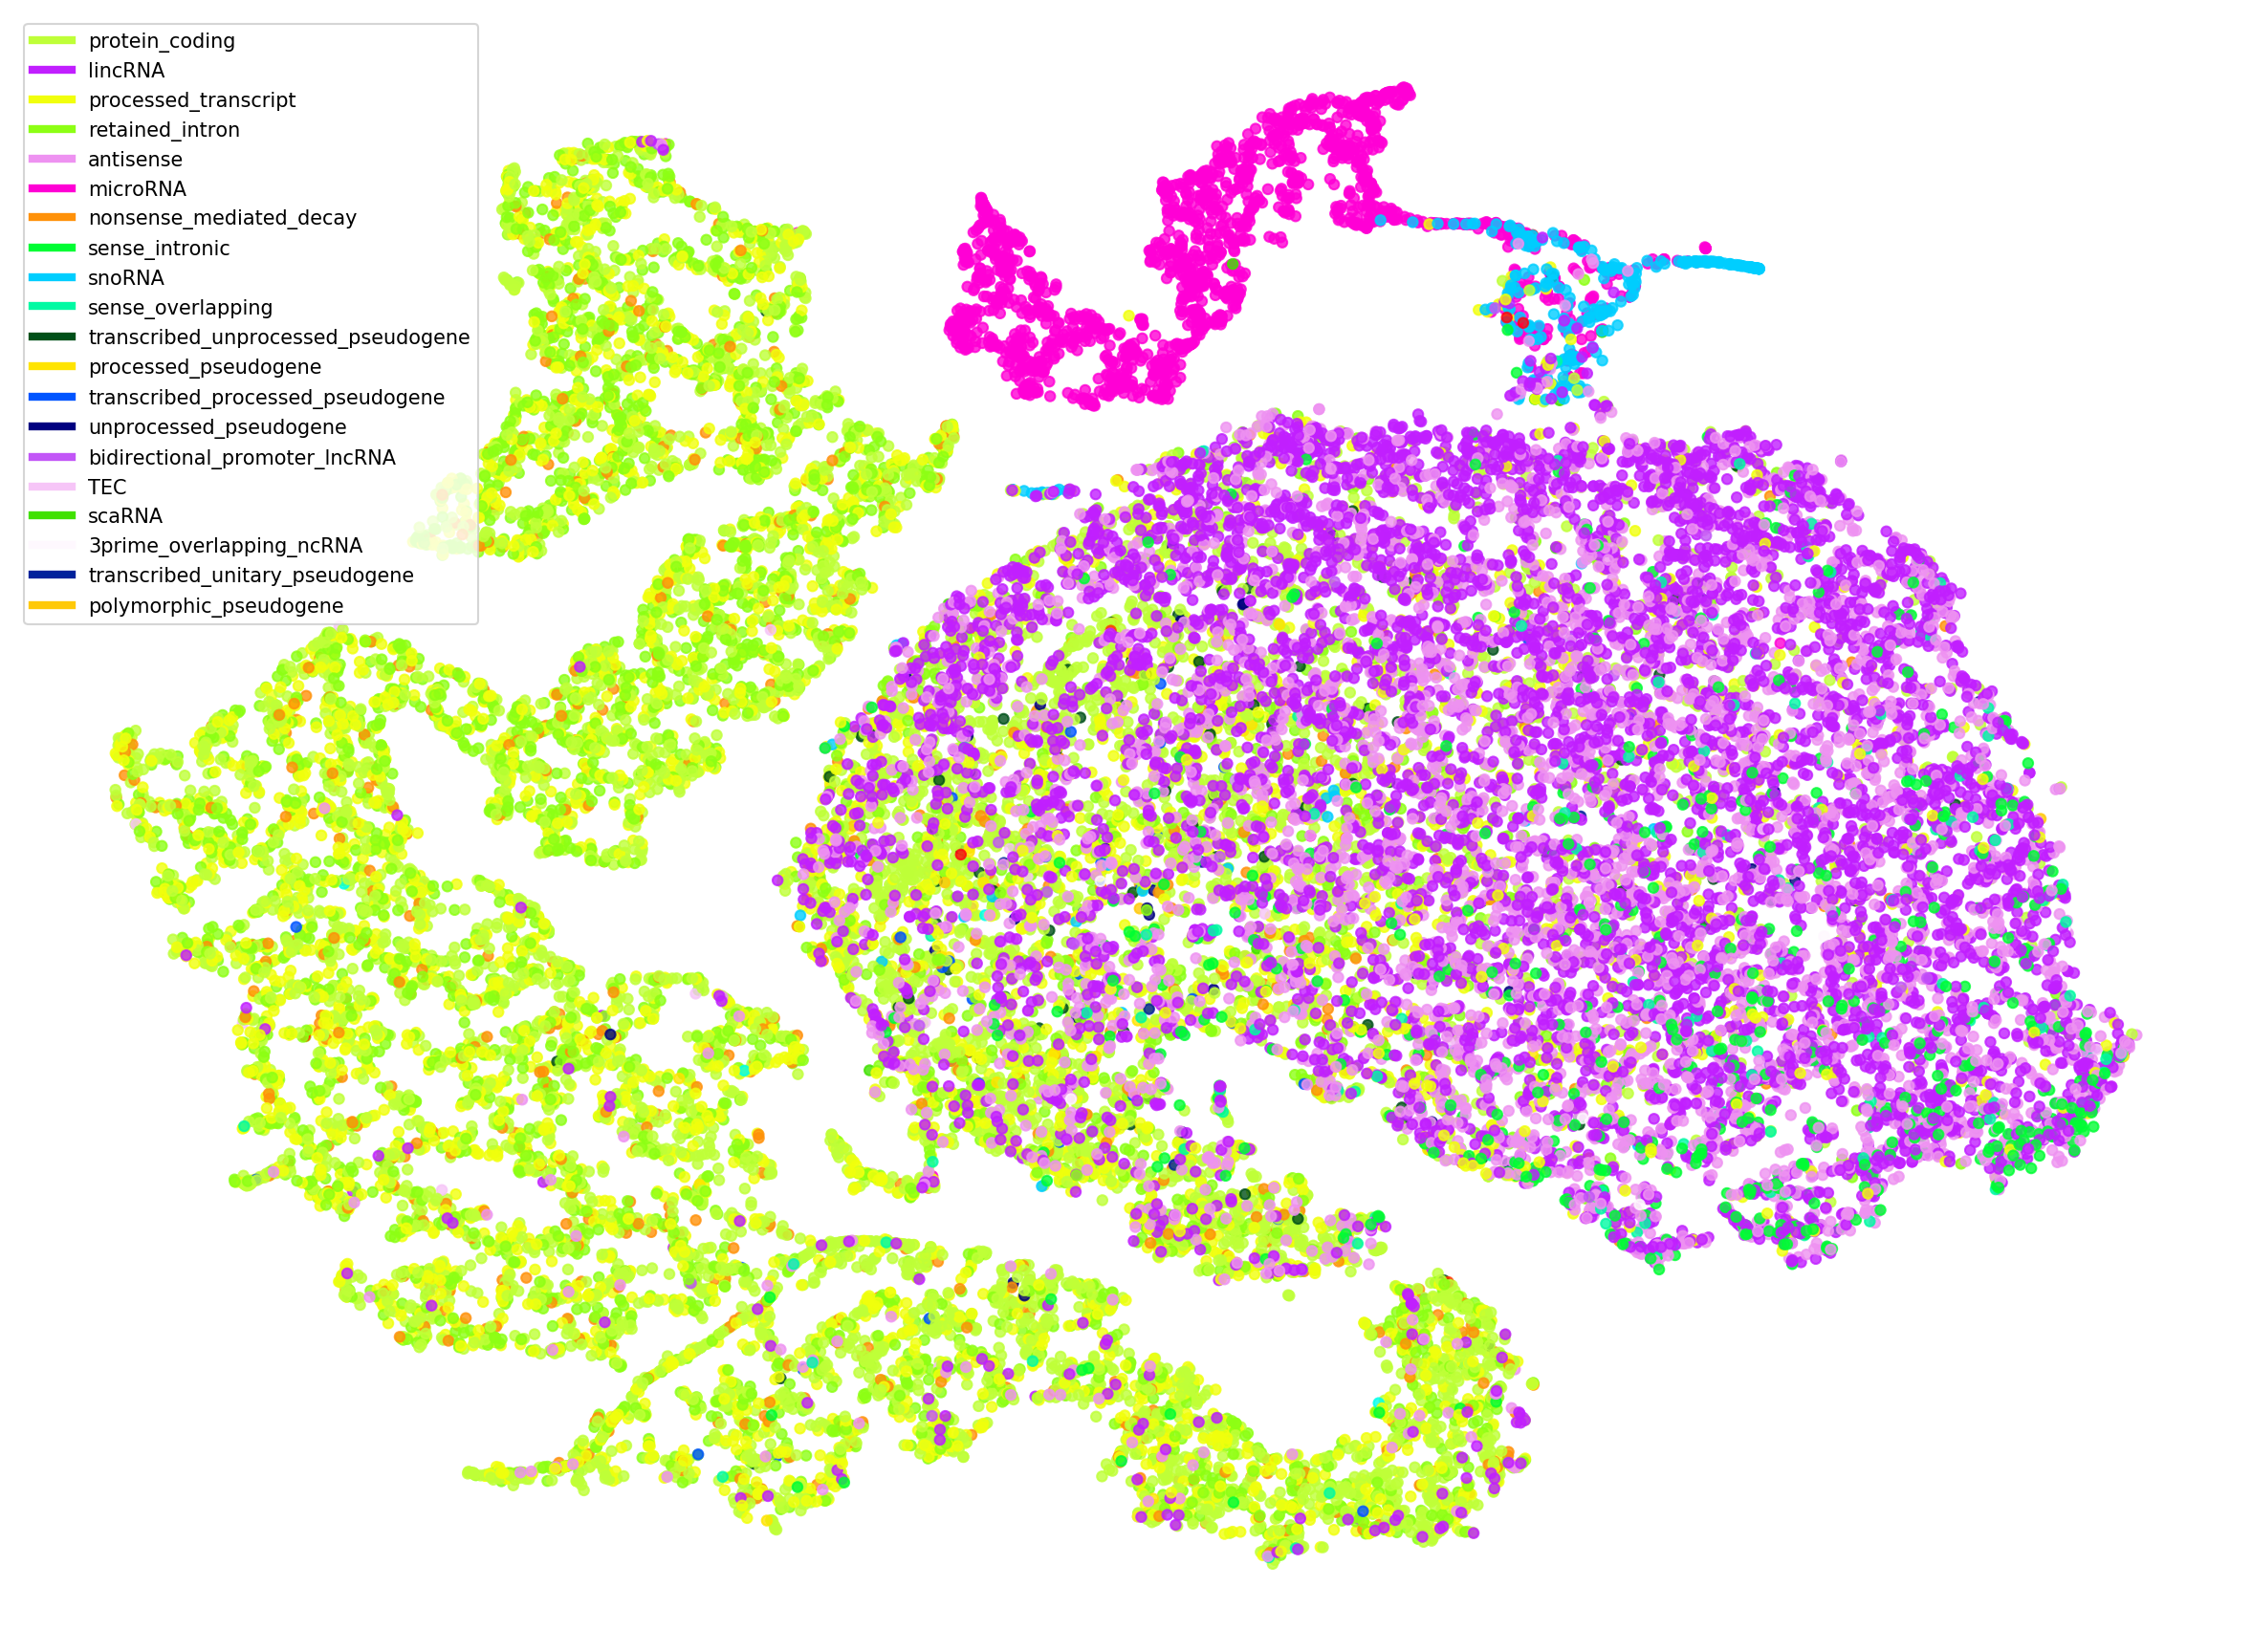

In [28]:
# siamese.process_embeddings(variable_length=False)
# delattr(siamese, "node_pos")
visualize_embedding(siamese, network=network, node_label="locus_type", 
                    cmap="gist_ncar",)

In [ ]:
siamese.process_embeddings(variable_length=True, minlen=200)
delattr(siamese, "node_pos")
visualize_embedding(siamese, network=network, node_label="locus_type", 
                    cmap="gist_ncar",)

In [ ]:
# nx.write_edgelist(network.G.subgraph(nodelist), "./moge/data/Networks/{}.edgelist".format(center_node))

In [ ]:
plot_bokeh_graph(network.G.subgraph(nodelist), node_pos=layout,
                 node_label=network.genes_info.loc[nodelist, "locus_type"].values.tolist())

# AUC Rate

%%javascript
Jupyter.notebook.session.delete();